#### We have used 4 different datasets in this project. We first split each dataset into train and test set. After splitting, we merge train set of each dataset and shuffle them. For ML modelling, we again split this new dataset into train and validation set. Then we test this model on individual test sets (that we created in the beginning).

In [1]:
import numpy as np       
import pandas as pd       
import matplotlib.pyplot as plt   # for data visualisation
import itertools
import re   # for string operations

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# hyperparameter tuning 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split    # train test split
# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
# transforming text into numerical format
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.4 MB/s eta 0:00:00


In [3]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <b> Splitting the datasets into train and test </b>

In [5]:
# Dataset link:  https://www.kaggle.com/competitions/fake-news/data
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/Fake News Detection/train.csv')
df1.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
train1, test1 = train_test_split(df1, test_size=0.2, stratify=df1.label)

In [7]:
# Dataset link:  https://drive.google.com/file/d/1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q/view
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/Fake News Detection/news.csv')
df2.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [8]:
# encoding the target variable into numerical format
encoder = {'label': {'FAKE':1, 'REAL':0}}
df2 = df2.replace(encoder)

In [9]:
train2, test2 = train_test_split(df2, test_size=0.2, stratify=df2.label)

In [10]:
# Dataset link:  https://www.kaggle.com/datasets/mohamadalhasan/a-fake-news-dataset-around-the-syrian-war
df3 = pd.read_csv('/content/fake_news.csv',encoding='latin')
df3.rename(columns={'article_title':'title', 'article_content':'text'}, inplace=True)
df3.head() # 0 means FAKE news and 1 means TRUE news in this this dataset

,unit_id,title,text,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


In [11]:
# creating new target variable so that FAKE news are represented by 1 and TRUE news by 0
df3['label'] = df3['labels'].apply(lambda x: 1 if x==0 else 0)

In [12]:
train3, test3 = train_test_split(df3, test_size=0.2, stratify=df3.label)

In [13]:
# Dataset link:  https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
fake_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/Fake News Detection/Fake.csv')
true_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/Fake News Detection/True.csv')

In [14]:
# creating labels
fake_news['label'] = 1
true_news['label'] = 0

# Mixing fake and true datasets
df4 = pd.concat([true_news,fake_news])
df4 = df4.sample(frac=1).reset_index(drop=True)

In [15]:
df4.head()

,title,text,subject,date,label
0,Mueller's Russia probe cost his office $3.2 mi...,WASHINGTON (Reuters) - U.S. Special Counsel Ro...,politicsNews,"December 5, 2017",0
1,OBAMA’S LAWLESS AMERICA: CA Police Tell Violen...,"Barack Obama s legacy will be a divided, lawle...",politics,"Jun 3, 2016",1
2,WATCH: ‘House’ Actor Hugh Laurie BURNS Trump ...,Meryl Streep and Viola Davis weren t the only ...,News,"January 9, 2017",1
3,Lebanon president: Saudi also holding Hariri's...,BEIRUT (Reuters) - Lebanese President Michel A...,worldnews,"November 15, 2017",0
4,Climate Change Pact Reached: Carbon Tax and Re...,John Kerry and Al Gore are jubilant that we ve...,politics,"Dec 12, 2015",1


In [16]:
train4, test4 = train_test_split(df4, test_size=0.2, stratify=df4.label)

# <b> Merging all the train datasets </b> 

In [17]:
train = pd.concat([train1.loc[:,['title','text','label']],
                  train2.loc[:,['title','text','label']],
                  train3.loc[:,['title','text','label']],
                  train4.loc[:,['title','text','label']]])

In [18]:
# checking null values
train.isna().sum()

title    443
text      25
label      0
dtype: int64

In [19]:
# removing null values
train.dropna(inplace=True)

In [20]:
# Checking for duplicate values
len(train[train.duplicated()])

5441

In [21]:
# removing duplicated values
train.drop_duplicates(inplace=True)

In [22]:
train = train.sample(frac=1).reset_index(drop=True)

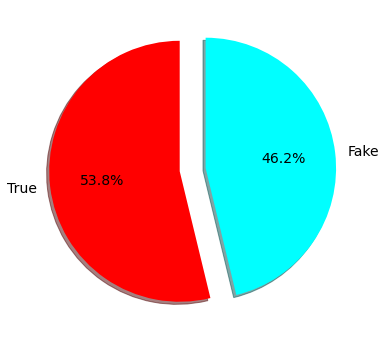

In [23]:
# Checking if our data is well balanced
plt.figure(figsize=(9,6))
plt.pie(train['label'].value_counts(),explode=[0.1,0.1],colors=['red','cyan'],startangle=90,shadow=True,labels=['True','Fake'],autopct='%1.1f%%',textprops={'fontsize': 14});

In [24]:
# removing the commoner inflexional endings from words in English
import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
stop_words = stopwords.words('english')
text_cleaning_re = '[^a-zA-Z]'

In [26]:
# function for text processing
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()     # use re package to removing everything that is not in letter
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [27]:
# text processing
train['text'] = train['text'].apply(lambda x: preprocess(x))
train['text'].head()

0    kuala lumpur malaysia two women charged murder...
1    hillary gives pay play whole new meaning lady ...
2    washington reuters president donald trump make...
3    amazing take fox news contributor stacey dash ...
4    war streets paris armed migrants fight running...
Name: text, dtype: object

In [28]:
X = train.text.values           # independent variable
y = train.label.values          # dependent variable

In [29]:
# splitting the dataset into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)

In [30]:
# transform our textual X to numerical so that our ML model can understand it and can work with it
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_features=5000,ngram_range=(1,3),max_df=0.7)

tfidf_train = tfidf_v.fit_transform(X_train).toarray()
tfidf_val = tfidf_v.transform(X_val).toarray()

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# <b> RandomForest Classifier </b>

### <b> Hyperparameter tuning </b>

In [32]:
# rf_clf = RandomForestClassifier()

# # Hyperparameter Grid
# rf_grid = {'n_estimators' : [100,150],
#         'max_depth' : [4,6,8],
#         'min_samples_split' : [50,80],
#         'min_samples_leaf' : [46,60]}

# # RandomSearch to find the best parameters
# rf_random = RandomizedSearchCV(rf_clf, param_distributions= rf_grid, scoring = 'accuracy', cv=5)
# rf_random.fit(tfidf_train,y_train)

# rf_random.best_params_

In [33]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=50, min_samples_leaf=46)
rf_clf.fit(tfidf_train,y_train)
tr_preds = rf_clf.predict(tfidf_train)  # predicting train
preds = rf_clf.predict(tfidf_val)       # predicting validation

In [34]:
print('Train accuracy:',accuracy_score(y_train, tr_preds))
print('Validation accuracy:',accuracy_score(y_val, preds))

Train accuracy: 0.8766711229946524
Validation accuracy: 0.8709893048128342


In [35]:
# train classification report for RandomForest
print(classification_report(y_train,tr_preds))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     22528
           1       0.92      0.81      0.86     19360

    accuracy                           0.88     41888
   macro avg       0.88      0.87      0.87     41888
weighted avg       0.88      0.88      0.88     41888



In [36]:
# validation classification report for RandomForest
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      5632
           1       0.91      0.80      0.85      4840

    accuracy                           0.87     10472
   macro avg       0.88      0.87      0.87     10472
weighted avg       0.87      0.87      0.87     10472



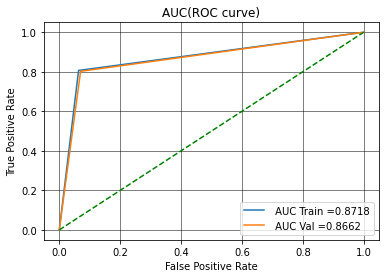

In [37]:
# train and validation ROC-AUC curve for RandomForest

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, tr_preds)
test_fpr, test_tpr, te_thresholds = roc_curve(y_val, preds)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC Train ="+str(auc(train_fpr, train_tpr).round(4)))
plt.plot(test_fpr, test_tpr, label=" AUC Val ="+str(auc(test_fpr, test_tpr).round(4)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Confusion matrix, without normalization


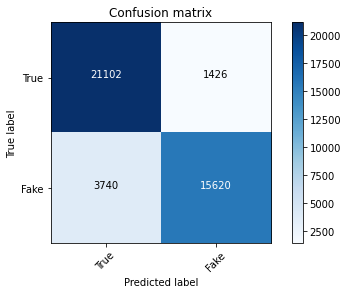

In [38]:
# train confusion matrix for RandomForest
cm_train = confusion_matrix(y_train,tr_preds)
plot_confusion_matrix(cm_train,classes=['True','Fake'])

Confusion matrix, without normalization


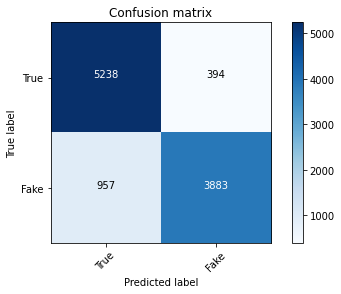

In [39]:
# validation confusion matrix for RandomForest
cm_test = confusion_matrix(y_val,preds)
plot_confusion_matrix(cm_test,classes=['True','Fake'])

# <b> Logistic Regression </b>

### <b> Hyperparameter tuning </b>

In [40]:
# lr = LogisticRegression(fit_intercept=True, max_iter=10000)

# # Hyperparameter Grid
# lr_grid = {'C':[0.1,0.5,0.8,1,2,3,5,8,10,20,50,100]}

# # RandomSearch to find the best parameters
# lr_random = RandomizedSearchCV(lr, param_distributions= lr_grid, scoring = 'roc_auc', cv=5)
# lr_random.fit(tfidf_train,y_train)

# lr_random.best_params_

In [41]:
# lr = LogisticRegression(fit_intercept=True, max_iter=10000)

# # Hyperparameter tuning using BayesSearch
# lr_bayes = BayesSearchCV(estimator=lr,
#                        search_spaces = {'C' : Real(1e-5, 1e+2, prior='log-uniform') },
#                        cv = 5, scoring='roc_auc', n_iter=32)
# lr_bayes.fit(tfidf_train,y_train)

In [42]:
lr = LogisticRegression(C=2, max_iter=10000)
# lr = lr_bayes.best_estimator_
lr.fit(tfidf_train,y_train)
tr_preds = lr.predict(tfidf_train)
preds = lr.predict(tfidf_val)

In [43]:
print('Train accuracy:',accuracy_score(y_train, tr_preds))
print('Validation accuracy:',accuracy_score(y_val, preds))

Train accuracy: 0.958627769289534
Validation accuracy: 0.9420359052711994


In [44]:
print(classification_report(y_train, tr_preds))       # train

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22528
           1       0.96      0.95      0.96     19360

    accuracy                           0.96     41888
   macro avg       0.96      0.96      0.96     41888
weighted avg       0.96      0.96      0.96     41888



In [45]:
print(classification_report(y_val, preds))     # validation

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5632
           1       0.94      0.94      0.94      4840

    accuracy                           0.94     10472
   macro avg       0.94      0.94      0.94     10472
weighted avg       0.94      0.94      0.94     10472



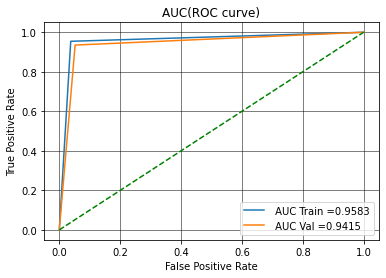

In [46]:
# train and validation ROC-AUC curve for Logistic Regression
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, tr_preds)
test_fpr, test_tpr, te_thresholds = roc_curve(y_val, preds)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC Train ="+str(auc(train_fpr, train_tpr).round(4)))
plt.plot(test_fpr, test_tpr, label=" AUC Val ="+str(auc(test_fpr, test_tpr).round(4)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Confusion matrix, without normalization


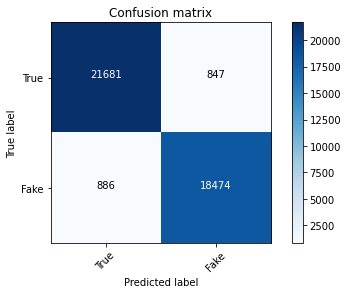

In [47]:
# train confusion matrix for Logistic Regession
cm_train = confusion_matrix(y_train,tr_preds)
plot_confusion_matrix(cm_train,classes=['True','Fake'])

Confusion matrix, without normalization


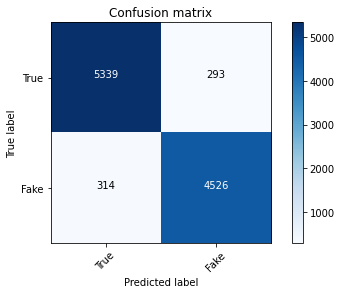

In [48]:
# validation confusion matrix for Logistic Regession
cm_test = confusion_matrix(y_val,preds)
plot_confusion_matrix(cm_test,classes=['True','Fake'])

# <b> Testing on different datasets </b>

## <b> test1 </b>

In [49]:
test1 = test1.dropna().reset_index(drop=True)
X1 = test1.title.values
X1_tfidf = tfidf_v.transform(X1).toarray()
test1['label_rf'] = rf_clf.predict(X1_tfidf)

In [50]:
accuracy_score(test1.label,test1.label_rf)    # RandomForest model

0.43946064942212437

In [51]:
print(classification_report(test1.label,test1.label_rf))    # RandomForest model

              precision    recall  f1-score   support

           0       0.72      0.03      0.05      2071
           1       0.43      0.99      0.60      1563

    accuracy                           0.44      3634
   macro avg       0.58      0.51      0.33      3634
weighted avg       0.60      0.44      0.29      3634



Confusion matrix, without normalization


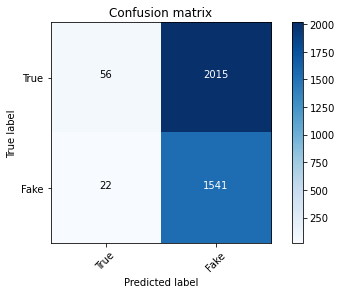

In [52]:
cm1_rf = confusion_matrix(test1.label,test1.label_rf)       # RandomForest model
plot_confusion_matrix(cm1_rf,classes=['True','Fake'])

In [53]:
test1['label_lr'] = lr.predict(X1_tfidf)

In [54]:
accuracy_score(test1.label,test1.label_lr)      # Logistic Regression model

0.6172261970280682

In [55]:
print(classification_report(test1.label,test1.label_lr))    # Logistic Regression model

              precision    recall  f1-score   support

           0       0.96      0.34      0.51      2071
           1       0.53      0.98      0.69      1563

    accuracy                           0.62      3634
   macro avg       0.74      0.66      0.60      3634
weighted avg       0.77      0.62      0.58      3634



Confusion matrix, without normalization


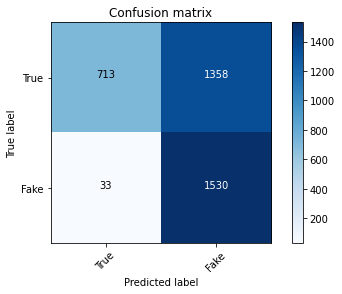

In [56]:
cm1_lr = confusion_matrix(test1.label,test1.label_lr)     # Logistic Regression model
plot_confusion_matrix(cm1_lr,classes=['True','Fake'])

## <b> test2 </b>

In [57]:
test2 = test2.dropna().reset_index(drop=True)
X2 = test2.text.values
X2_tfidf = tfidf_v.transform(X2).toarray()
test2['label_rf'] = rf_clf.predict(X2_tfidf)
test2.head()

,Unnamed: 0,title,text,label,label_rf
0,1253,Inside Bernie Sanders’s quest to win over Neva...,"EAST LAS VEGAS — ""Nevada is especially importa...",0,0
1,2647,Former Marine guilty of murder in 'American Sn...,A former Marine was found guilty late Tuesday ...,0,0
2,3451,Is the Supreme Court poised for a shift to the...,Washington (CNN) The nine Supreme Court justic...,0,0
3,10489,YouTube bans 'Clinton's black son',Print Side-by-side of Bill Clinton and Danney ...,1,0
4,5909,Hillary To Be Indicted After Election: Trump R...,Hillary To Be Indicted After Election: Trump R...,1,1


In [58]:
accuracy_score(test2.label,test2.label_rf)      # RandomForest model

0.7434885556432518

In [59]:
print(classification_report(test2.label,test2.label_rf))      # RandomForest model

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       634
           1       0.75      0.72      0.74       633

    accuracy                           0.74      1267
   macro avg       0.74      0.74      0.74      1267
weighted avg       0.74      0.74      0.74      1267



Confusion matrix, without normalization


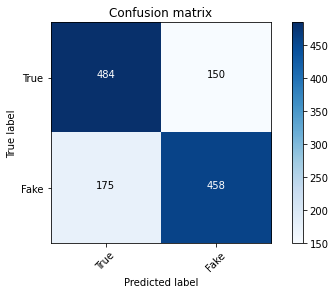

In [60]:
cm2_rf = confusion_matrix(test2.label,test2.label_rf)       # RandomForest model
plot_confusion_matrix(cm2_rf,classes=['True','Fake'])

In [61]:
test2['label_lr'] = lr.predict(X2_tfidf)

In [62]:
accuracy_score(test2.label,test2.label_lr)      # Logistic Regression model

0.856353591160221

In [63]:
print(classification_report(test2.label,test2.label_lr))      # Logistic Regression model

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       634
           1       0.80      0.94      0.87       633

    accuracy                           0.86      1267
   macro avg       0.87      0.86      0.86      1267
weighted avg       0.87      0.86      0.86      1267



Confusion matrix, without normalization


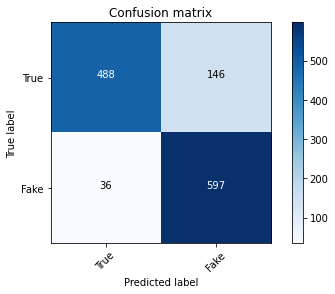

In [64]:
cm2_lr = confusion_matrix(test2.label,test2.label_lr)     # Logistic Regression model
plot_confusion_matrix(cm2_lr,classes=['True','Fake'])

## <b> test3 </b>

In [65]:
test3 = test3.dropna().reset_index(drop=True)
X3 = test3.text.values
X3_tfidf = tfidf_v.transform(X3).toarray()
test3['label_rf'] = rf_clf.predict(X3_tfidf)
test3.head()

,unit_id,title,text,source,date,location,labels,label,label_rf
0,1923102934,Syria Regime kills 25 civilians in Hama airstr...,Date of publication 1 September 2016 At least ...,alaraby,9/1/2016,hama,0,1,0
1,1962495719,50 ISIS Terrorists Killed in Syrian Army Anti-...,Thu Dec 29 2016 50 ISIS Terrorists Killed in S...,alalam,12/29/2016,homs,1,0,0
2,1923848284,Group IS group land mines killed wounded dozen...,Group IS group land mines killed wounded dozen...,ahram,10/6/2016,aleppo,0,1,0
3,1924058204,Airstrikes on clinic kill 5 medics in Syrias A...,Published September 21 2016 Five medics were k...,dailysabah,9/7/2016,aleppo,1,0,0
4,1918150033,Toxic Gas Dropped on Syrian Town After Russian...,Posted on August 3 2016 by Jordan Dakamseh Tox...,asharqalawsat,8/3/2016,idlib,0,1,0


In [66]:
accuracy_score(test3.label,test3.label_rf)      # RandomForest model

0.5279503105590062

In [67]:
print(classification_report(test3.label,test3.label_rf))      # RandomForest model

              precision    recall  f1-score   support

           0       0.53      0.86      0.66        85
           1       0.50      0.16      0.24        76

    accuracy                           0.53       161
   macro avg       0.52      0.51      0.45       161
weighted avg       0.52      0.53      0.46       161



Confusion matrix, without normalization


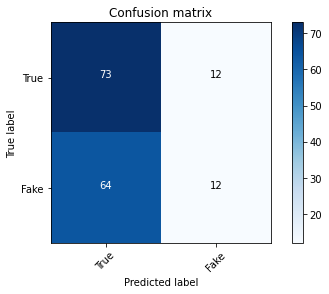

In [68]:
cm3_rf = confusion_matrix(test3.label,test3.label_rf)       # RandomForest model
plot_confusion_matrix(cm3_rf,classes=['True','Fake'])

In [69]:
test3['label_lr'] = lr.predict(X3_tfidf)

In [70]:
accuracy_score(test3.label,test3.label_lr)      # Logistic Regression model

0.5031055900621118

In [71]:
print(classification_report(test3.label,test3.label_lr))      # Logistic Regression model

              precision    recall  f1-score   support

           0       0.53      0.55      0.54        85
           1       0.47      0.45      0.46        76

    accuracy                           0.50       161
   macro avg       0.50      0.50      0.50       161
weighted avg       0.50      0.50      0.50       161



Confusion matrix, without normalization


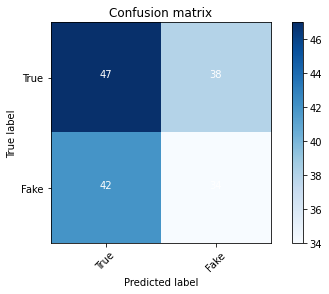

In [72]:
cm3_lr = confusion_matrix(test3.label,test3.label_lr)       # Logistic Regression model
plot_confusion_matrix(cm3_lr,classes=['True','Fake'])

## <b> test4 </b>

In [73]:
test4 = test4.dropna().reset_index(drop=True)
X4 = test4.text.values
X4_tfidf = tfidf_v.transform(X4).toarray()
test4['label_rf'] = rf_clf.predict(X4_tfidf)
test4.head()

,title,text,subject,date,label,label_rf
0,NH Car Dealer Gives Away Free AR-15s With Car...,Mike Hagan has a used car dealership and repai...,News,"June 18, 2016",1,1
1,“LIBERAL BULLY” Middle School Teacher Tells St...,Outspoken conservative CJ Pearson hasn t heard...,left-news,"Oct 18, 2015",1,1
2,Ousted Catalan leader says will not return to ...,MADRID (Reuters) - Dismissed Catalan leader Ca...,worldnews,"November 1, 2017",0,0
3,Witness says injured in stampede at London sta...,LONDON (Reuters) - A woman at London s Parsons...,worldnews,"September 15, 2017",0,0
4,White House unveils measures to help inmates f...,WASHINGTON (Reuters) - The Obama administratio...,politicsNews,"June 24, 2016",0,0


In [74]:
accuracy_score(test4.label,test4.label_rf)      # RandomForest model

0.9155902004454343

In [75]:
print(classification_report(test4.label,test4.label_rf))      # RandomForest model

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      4284
           1       1.00      0.84      0.91      4696

    accuracy                           0.92      8980
   macro avg       0.92      0.92      0.92      8980
weighted avg       0.93      0.92      0.92      8980



Confusion matrix, without normalization


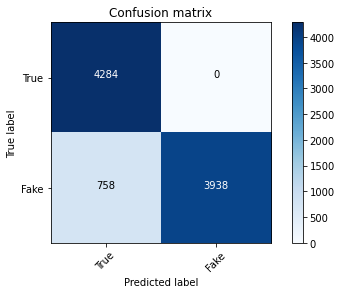

In [76]:
cm4_rf = confusion_matrix(test4.label,test4.label_rf)       # RandomForest model
plot_confusion_matrix(cm4_rf,classes=['True','Fake'])

In [77]:
test4['label_lr'] = lr.predict(X4_tfidf)

In [78]:
accuracy_score(test4.label,test4.label_lr)      # Logistic Regression model

0.9678173719376392

In [79]:
print(classification_report(test4.label,test4.label_lr))      # Logistic Regression model

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4284
           1       0.99      0.94      0.97      4696

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



Confusion matrix, without normalization


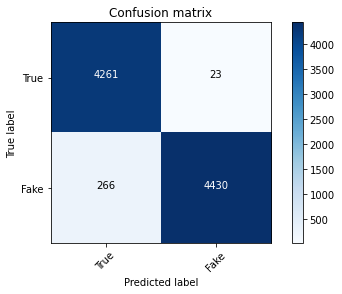

In [80]:
cm4_lr = confusion_matrix(test4.label,test4.label_lr)       # Logistic Regression model
plot_confusion_matrix(cm4_lr,classes=['True','Fake'])